In [7]:
"""
Demo showing how km_dict and insegtprobannotator may be used together for
interactive segmentation. 

@author: vand and abda
"""

import sys
import skimage.io
import skimage.data
import skimage.transform
import numpy as np
%gui qt
patch_dir = '/Users/vand/Documents/PROJECTS2/InSegt/pycode'
import sys
if patch_dir not in sys.path:
    sys.path.append(patch_dir)
import insegtprobannotator
import km_dict
import feat_seg
import PyQt5.QtCore
import glob

import matplotlib.pyplot as plt
import matplotlib.colors
%matplotlib notebook

import time



Loading image


<IPython.core.display.Javascript object>


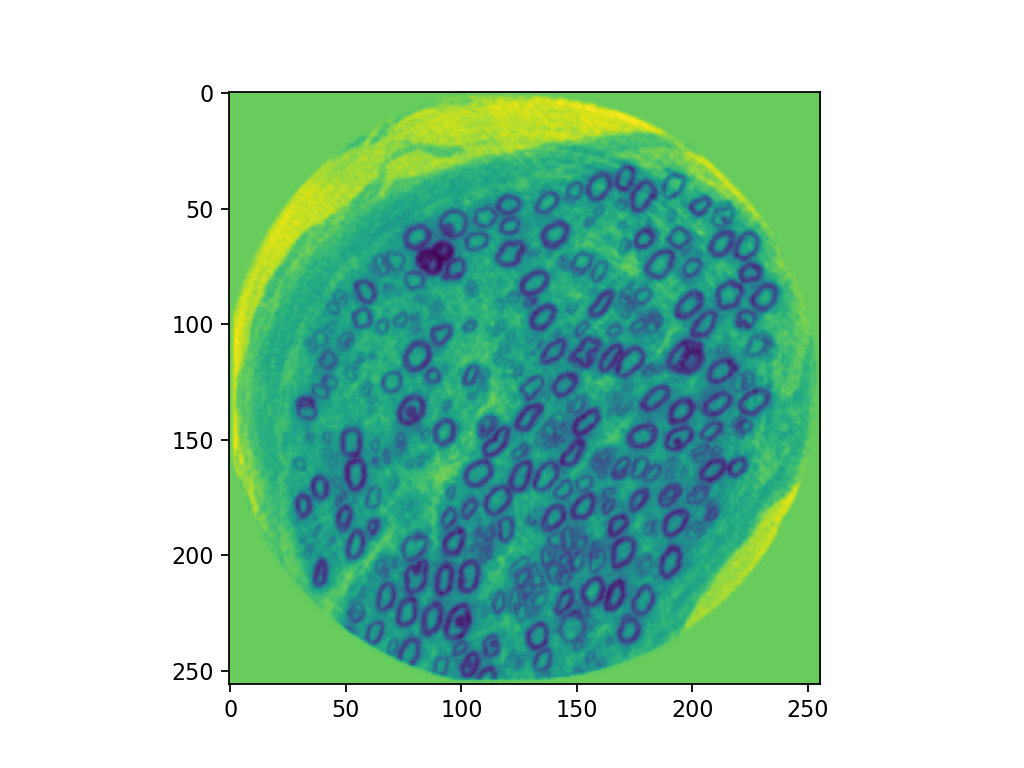

In [8]:
#%% EXAMPLE: nerve fibres

in_dir = '/Users/vand/Documents/PROJECTS2/InSegt/data/nerve/'
file_names = sorted(glob.glob(in_dir + '*.png'))
n_im = len(file_names)
n = 25

sc_fac = 0.75
# loading image
print('Loading image')
image = skimage.transform.rescale(skimage.io.imread(file_names[n]), sc_fac, preserve_range = True)

fig, ax = plt.subplots(1)
ax.imshow(image)
plt.show()


In [9]:
int_patch_size = 9
branching_factor = 5
number_layers = 5
number_training_patches = 200000
normalization = False

patch_size_feat = 5
n_train = 50000
n_keep = 25
order_keep = (True, True, True)

image_float = image.astype(np.float)/255

# Compute feature image
feat_im, vec, mean_patch, norm_fac = feat_seg.get_uni_pca_feat(image_float, patch_size_feat, n_train, n_keep, order_keep, sigma = 2)
feat_im = np.asarray(feat_im.transpose(2,0,1), order='C')

# Build tree
T = km_dict.build_km_tree(feat_im, 1, branching_factor, number_training_patches, number_layers, normalization)

# Search km-tree and get assignment
A, number_nodes = km_dict.search_km_tree(feat_im, T, branching_factor, normalization)
# number of repetitions for updating the segmentation
number_repetitions = 2


def processing_function(labels):
    r,c = labels.shape
    l = np.max(labels)+1
    if(l>1):
        label_image = np.zeros((r,c,l))
        for k in range(number_repetitions):
            for i in range(1,l):
                label_image[:,:,i] = (labels == i).astype(float)
            D = km_dict.improb_to_dictprob(A, label_image[:,:,1:], number_nodes, int_patch_size) # Dictionary
            P = km_dict.dictprob_to_improb(A, D, int_patch_size) # Probability map
            labels = (np.argmax(P,axis=2) + 1)*(np.sum(P,axis=2)>0)# Segmentation
    else:
        P = np.empty((r,c,0))
        D = None
    return labels, P.transpose(2,0,1), D

pf = lambda labels: processing_function(labels)[:2]

print('Showtime')    

# showtime
app = PyQt5.QtCore.QCoreApplication.instance()
if app is None:
    app = insegtprobannotator.PyQt5.QtWidgets.QApplication(sys.argv)
ex = insegtprobannotator.InSegtProbAnnotator(image.astype(np.uint8), pf)
app.exec_()

number of training patches 65536
Showtime
Starting InSegt annotator. For help, hit 'H'.


0

Iteration: 000 of 342 Time 0.192 sec
Iteration: 010 of 342 Time 1.27 sec
Iteration: 020 of 342 Time 1.23 sec
Iteration: 030 of 342 Time 1.25 sec
Iteration: 040 of 342 Time 1.23 sec
Iteration: 050 of 342 Time 1.24 sec
Iteration: 060 of 342 Time 1.23 sec
Iteration: 070 of 342 Time 1.23 sec
Iteration: 080 of 342 Time 1.24 sec
Iteration: 090 of 342 Time 1.23 sec
Iteration: 100 of 342 Time 1.23 sec
Iteration: 110 of 342 Time 1.26 sec
Iteration: 120 of 342 Time 1.23 sec
Iteration: 130 of 342 Time 1.24 sec
Iteration: 140 of 342 Time 1.23 sec
Iteration: 150 of 342 Time 1.22 sec
Iteration: 160 of 342 Time 1.22 sec
Iteration: 170 of 342 Time 1.22 sec
Iteration: 180 of 342 Time 1.24 sec
Iteration: 190 of 342 Time 1.23 sec
Iteration: 200 of 342 Time 1.24 sec
Iteration: 210 of 342 Time 1.24 sec
Iteration: 220 of 342 Time 1.24 sec
Iteration: 230 of 342 Time 1.26 sec
Iteration: 240 of 342 Time 1.33 sec
Iteration: 250 of 342 Time 1.24 sec
Iteration: 260 of 342 Time 1.23 sec
Iteration: 270 of 342 Time 

<IPython.core.display.Javascript object>


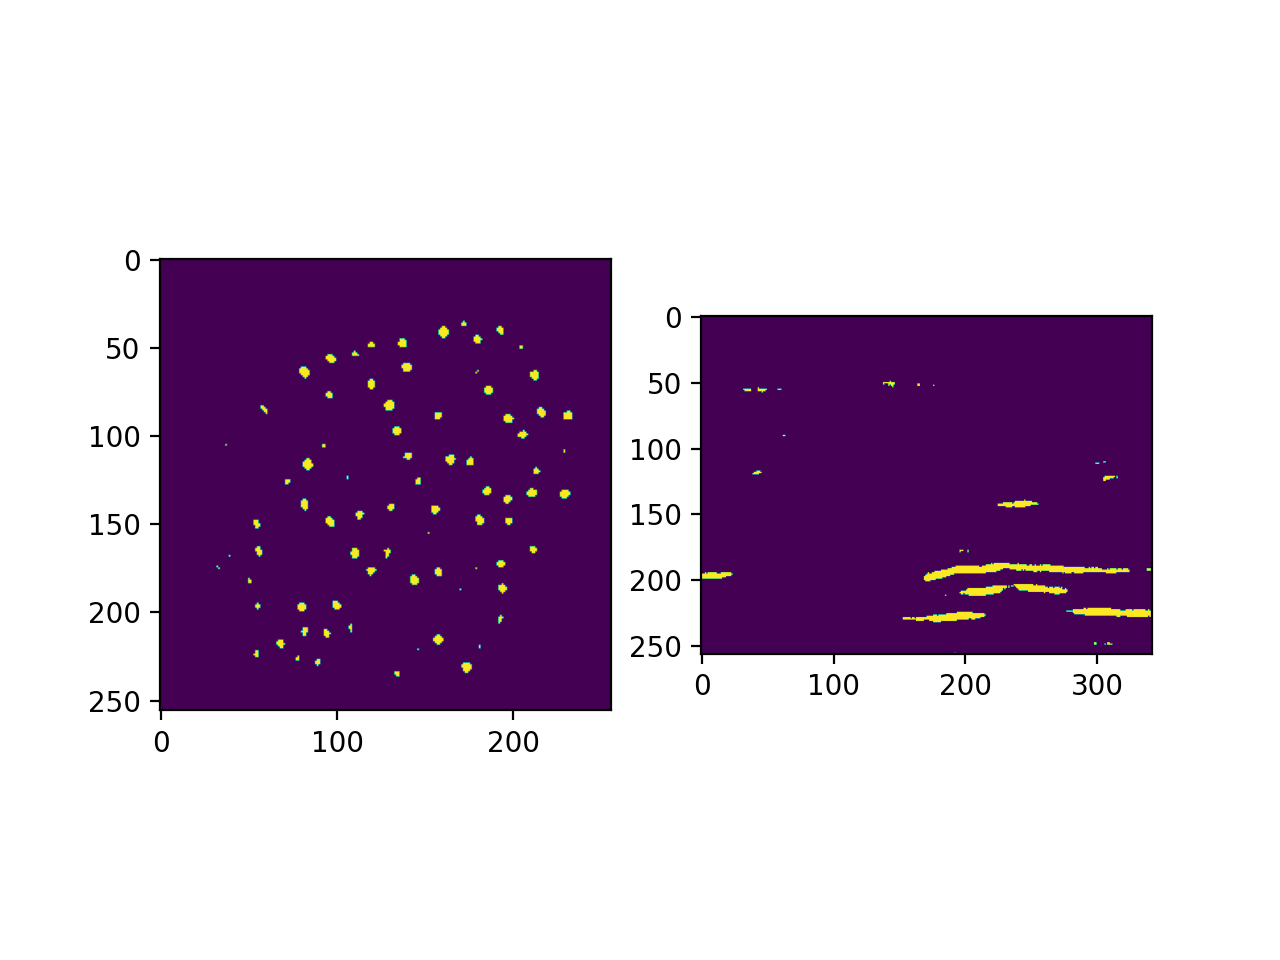

In [4]:
# Get the labels
labels = ex.rgbaToLabels(ex.pixmapToArray(ex.annotationPix))
# Compute dictionary
segmentation, P_out, D = processing_function(labels)
r,c = image.shape
V = np.empty((r,c,n_im))
t = time.time()
for i in range(0,n_im):
    im_in = skimage.transform.rescale(skimage.io.imread(file_names[i]), sc_fac, preserve_range = True).astype(np.float)/255
    feat_im_b = feat_seg.get_uni_pca_feat(im_in, vec = vec, mean_patch = mean_patch, sigma = 2, norm_fac = norm_fac)[0].transpose(2,0,1)# Compute feature image
    A_b = km_dict.search_km_tree(feat_im_b, T, branching_factor, normalization)[0]
    V[:,:,i] = km_dict.dictprob_to_improb(A_b, D, int_patch_size)[:,:,0]
    if (i % 10 == 0):
        print(f'Iteration: {i:03.0f} of {n_im:03.0f} Time {time.time()-t:0.3} sec')
        t = time.time()


fig, ax = plt.subplots(1,2)
ax[0].imshow(V[:,:,10]<0.5)
ax[1].imshow(V[:,100,:]<0.5)
plt.show()



In [10]:
import vizVTK
vizVTK.visgray(((V>0.5)*255).astype(np.uint8), scalarOpacity = {0: 1.0, 130: 0.001}, 
               gradientOpacity=None, colorTransfer = {0: (0.0, 1.0, 1.0), 255: (1.0, 0.0, 0.0)},
               windowSize = (1600,1600))


ModuleNotFoundError: No module named 'vtk'